<a href="https://colab.research.google.com/github/nikhildr22/Speech-Emotion-Recognition/blob/master/Final_Copy_of_speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
''' Using Tensorflow 1.x '''

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
''' listing directories '''
!ls

sample_data


In [3]:
''' Downloading the dataset from the website in zip compressed format '''
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

--2020-08-18 21:56:17--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  4.09MB/s    in 40s     

2020-08-18 21:56:59 (4.95 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]



In [4]:
''' creating a folder - 'dataset' to keep the data '''
!mkdir dataset
!ls

Audio_Speech_Actors_01-24.zip  dataset	sample_data


In [5]:
''' unzipping the dataset into the destination folder 'dataset' '''
!unzip -q Audio_Speech_Actors_01-24.zip -d dataset

In [6]:
''' listing directories '''
!ls

Audio_Speech_Actors_01-24.zip  dataset	sample_data


In [7]:
''' Installing soundfile module via pip '''
!pip install soundfile

In [8]:
''' importing required modules '''
import librosa
from tqdm import tqdm
import soundfile
from scipy.io import wavfile
import os, glob, pickle
import numpy as np
from scipy.fftpack import dct
import matplotlib.pyplot as plt

In [9]:
''' creating a directory to keep clean files '''
!mkdir clean 

In [10]:
''' downsampling audio files to 16KHz and storing them in /clean directory ''' 
for f in tqdm(glob.glob("dataset/*/*")):
    signal, rate = librosa.load(path=f, sr=16000)
    wavfile.write(filename='clean/'+f[-24:],rate=rate,data=signal)

100%|██████████| 1440/1440 [06:48<00:00,  3.52it/s]


In [11]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to be observed in our project
observed_emotions=['sad','angry','happy','neutral']

In [12]:
''' Creating a pandas dataframe for structured handling of files in the dataset '''
import pandas as pd
#Dataframe will contain 2 columns 'file' and 'emotion'
dataframe = pd.DataFrame(columns=['file', 'emotion'])

In [13]:
''' filling the dataframe rows with values '''
for file in tqdm(glob.glob("clean/*")):
        file_name=os.path.basename(file[-24:])
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue

        dataframe = dataframe.append({'file': file, 'emotion': emotion}, ignore_index=True)

100%|██████████| 1440/1440 [00:01<00:00, 723.63it/s]


In [14]:
dataframe.describe()

,file,emotion
count,672,672
unique,672,4
top,clean/03-01-05-02-01-02-05.wav,happy
freq,1,192


In [15]:
''' Dividing the dataframe into test and train dataframes '''
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframe, test_size=0.2)

In [16]:
train.describe()

,file,emotion
count,537,537
unique,537,4
top,clean/03-01-01-01-02-01-13.wav,angry
freq,1,160


In [17]:
train.head()

,file,emotion
109,clean/03-01-03-02-01-01-18.wav,happy
609,clean/03-01-04-01-01-01-13.wav,sad
428,clean/03-01-04-02-02-01-11.wav,sad
385,clean/03-01-05-01-02-01-04.wav,angry
359,clean/03-01-03-01-02-01-04.wav,happy


In [18]:
test.describe()

,file,emotion
count,135,135
unique,135,4
top,clean/03-01-04-01-01-01-08.wav,sad
freq,1,40


In [19]:
''' Defining a function for MFCC feature extraction '''

def find_mfcc(signal, sample_rate , numcep):
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    frame_size = 0.025
    frame_stride = 0.01

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB

    num_ceps = numcep
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-27
   
    return mfcc

In [20]:
''' preparing the training data for the model '''
x_train = []
y_train = []
for index,row in tqdm(train.iterrows()):
        file = row['file']
        emotion = row['emotion']
        with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            mfcc = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
            x_train.append(mfcc)
            y_train.append(emotion)


537it [00:07, 72.74it/s]


In [21]:
''' preparing the testing data for the model '''
x_test = []
y_test = []
for index,row in tqdm(test.iterrows()):
        file = row['file']
        emotion = row['emotion']
        with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            mfcc = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
            x_test.append(mfcc)
            y_test.append(emotion)

135it [00:01, 74.00it/s]


In [22]:
''' converting all the training and testing data into numpy arrays '''
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [23]:
'''Performing LabelEncoding for the categorical output data '''
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [24]:
label = LabelEncoder()
y_train = np_utils.to_categorical(label.fit_transform(y_train))
y_test = np_utils.to_categorical(label.fit_transform(y_test))

In [25]:
print('x_train shape = ',x_train.shape)
print('y_train shape = ',y_train.shape)
print('x_test shape = ',x_test.shape)
print('y_test shape = ',y_test.shape)

x_train shape =  (537, 26)
y_train shape =  (537, 4)
x_test shape =  (135, 26)
y_test shape =  (135, 4)


In [26]:
num_features = x_train.shape[1]
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 26


In [27]:
''' imports required for MLP classifier '''
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [28]:
#Initializing the Multi Layer Perceptron Classifier
MLP_model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, 
                    hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500,verbose=1)

In [29]:
#Training the model
MLP_model.fit(x_train,y_train)

Iteration 1, loss = 4.33032159
Iteration 2, loss = 2.92149532
Iteration 3, loss = 2.94872258
Iteration 4, loss = 2.38523747
Iteration 5, loss = 2.28862098
Iteration 6, loss = 2.15523904
Iteration 7, loss = 1.98535093
Iteration 8, loss = 1.98911227
Iteration 9, loss = 1.88689916
Iteration 10, loss = 1.79001228
Iteration 11, loss = 1.77876304
Iteration 12, loss = 1.72925784
Iteration 13, loss = 1.67593289
Iteration 14, loss = 1.65585201
Iteration 15, loss = 1.64801222
Iteration 16, loss = 1.63292805
Iteration 17, loss = 1.59925048
Iteration 18, loss = 1.59185091
Iteration 19, loss = 1.54431677
Iteration 20, loss = 1.56201933
Iteration 21, loss = 1.50423483
Iteration 22, loss = 1.52125431
Iteration 23, loss = 1.49989659
Iteration 24, loss = 1.46519751
Iteration 25, loss = 1.50483899
Iteration 26, loss = 1.43986459
Iteration 27, loss = 1.46735684
Iteration 28, loss = 1.43224151
Iteration 29, loss = 1.39082105
Iteration 30, loss = 1.37799469
Iteration 31, loss = 1.36468693
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [30]:
#Predicting the results for the test set data
y_pred=MLP_model.predict(x_test)

In [31]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 63.70%


In [32]:
''' imports required for CNN model '''
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten 
from tensorflow.keras.layers import MaxPooling1D,Dropout

In [33]:
''' reshaping data before feeding into the model '''
input_shape = (num_features,1)
num_files = x_train.shape[0]
x_train = x_train.reshape(num_files,num_features,1)

In [34]:
''' CNN model '''
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=(3), input_shape=input_shape))
cnn_model.add(Conv1D(64, kernel_size=(3)))
cnn_model.add(Conv1D(128, kernel_size=(3)))
cnn_model.add(MaxPooling1D(3))
cnn_model.add(Conv1D(64, kernel_size=(3)))
cnn_model.add(Conv1D(32, kernel_size=(3)))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(12, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [35]:
''' compiling the model and printing summary '''
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 128)           24704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 64)             24640     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 32)             6176      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [36]:
''' CNN model training '''
final = cnn_model.fit(x_train, y_train, epochs=500,verbose=1, batch_size=256, validation_split=0.2)

Train on 429 samples, validate on 108 samples
Epoch 1/500
429/429 [==============================] - 7s 17ms/sample - loss: 2.1944 - acc: 0.1981 - val_loss: 1.5620 - val_acc: 0.2870
Epoch 2/500
429/429 [==============================] - 0s 45us/sample - loss: 1.6658 - acc: 0.2844 - val_loss: 1.4485 - val_acc: 0.2685
Epoch 3/500
429/429 [==============================] - 0s 43us/sample - loss: 1.5560 - acc: 0.2378 - val_loss: 1.3989 - val_acc: 0.2130
Epoch 4/500
429/429 [==============================] - 0s 75us/sample - loss: 1.4293 - acc: 0.2937 - val_loss: 1.3454 - val_acc: 0.4444
Epoch 5/500
429/429 [==============================] - 0s 45us/sample - loss: 1.3733 - acc: 0.3100 - val_loss: 1.3299 - val_acc: 0.3241
Epoch 6/500
429/429 [==============================] - 0s 42us/sample - loss: 1.3802 - acc: 0.3077 - val_loss: 1.3222 - val_acc: 0.3056
Epoch 7/500
429/429 [==============================] - 0s 43us/sample - loss: 1.3818 - acc: 0.3310 - val_loss: 1.3057 - val_acc: 0.3241
Ep

In [37]:
''' reshaping testing data before feeding into the model '''
num_testfiles = y_test.shape[0]
x_test = x_test.reshape(num_testfiles,num_features,1)

In [38]:
''' evaluating the testing accuracy for the trained model '''
test_loss,test_accuracy = cnn_model.evaluate(x_test, y_test)
print('Testing accuracy is :',test_accuracy*100,'%')

135/135 [==============================] - 0s 1ms/sample - loss: 2.6894 - acc: 0.5852
Testing accuracy is : 58.5185170173645 %


In [39]:
''' imports required for playing sound files '''
import IPython.display as ipd

In [40]:
''' taking a random file from the testing data '''
random_data = test.sample()
file = random_data.iloc[0]['file']
print('file ',file[-24:])
original_emotion = random_data.iloc[0]['emotion']
ipd.Audio(filename=file,) # load a local WAV file

file  03-01-01-01-01-01-06.wav


In [41]:
def get_relation(index,value):
    emo = label.inverse_transform([index])[0]
    value = float(value) * 100
    return '{} - {:.10f}%'.format(emo,value)

In [42]:
''' extracting features from the random file and feeding it to the model for prediction '''
with soundfile.SoundFile(file) as sound_file:
    signal = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    feature = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
result = cnn_model.predict(feature.reshape(1,num_features,1))
for index,i in enumerate(result[0]):print(get_relation(index,i))
result = cnn_model.predict_classes(feature.reshape(1,num_features,1))
print('Original emotion is : ' + original_emotion)
print('identified emotion is : ' + label.inverse_transform(result)[0])

angry - 90.3789579868%
happy - 0.0000116683%
neutral - 9.5945432782%
sad - 0.0264896778%
Original emotion is : neutral
identified emotion is : angry


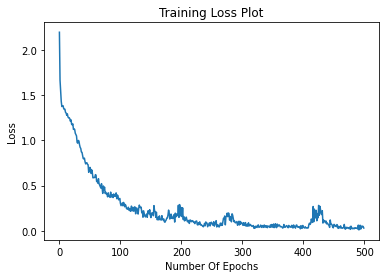

In [43]:
plt.plot(final.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Number Of Epochs')
plt.title('Training Loss Plot')
plt.show()

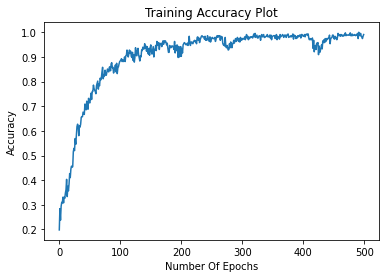

In [44]:
plt.plot(final.history['acc'])
plt.ylabel('Accuracy')
plt.xlabel('Number Of Epochs')
plt.title('Training Accuracy Plot')
plt.show()

In [45]:
print('predicted values for the test data: ',label.inverse_transform(cnn_model.predict_classes(x_test.reshape(len(x_test),num_features,1))))

predicted values for the test data:  ['angry' 'sad' 'happy' 'sad' 'happy' 'angry' 'happy' 'happy' 'sad' 'sad'
 'sad' 'angry' 'neutral' 'angry' 'neutral' 'sad' 'angry' 'angry' 'angry'
 'neutral' 'sad' 'happy' 'neutral' 'angry' 'happy' 'sad' 'happy' 'neutral'
 'sad' 'sad' 'happy' 'angry' 'sad' 'happy' 'angry' 'angry' 'sad' 'angry'
 'angry' 'angry' 'happy' 'angry' 'neutral' 'neutral' 'angry' 'sad'
 'neutral' 'neutral' 'angry' 'happy' 'happy' 'angry' 'sad' 'sad' 'happy'
 'sad' 'sad' 'happy' 'happy' 'angry' 'angry' 'sad' 'neutral' 'sad' 'happy'
 'neutral' 'happy' 'neutral' 'angry' 'angry' 'angry' 'angry' 'neutral'
 'angry' 'neutral' 'happy' 'happy' 'sad' 'sad' 'sad' 'sad' 'neutral'
 'neutral' 'sad' 'happy' 'happy' 'sad' 'angry' 'happy' 'neutral' 'angry'
 'angry' 'happy' 'happy' 'sad' 'happy' 'neutral' 'happy' 'neutral' 'angry'
 'angry' 'sad' 'happy' 'neutral' 'happy' 'neutral' 'sad' 'sad' 'happy'
 'sad' 'sad' 'happy' 'happy' 'sad' 'angry' 'angry' 'angry' 'angry' 'sad'
 'angry' 'angry' 'neut

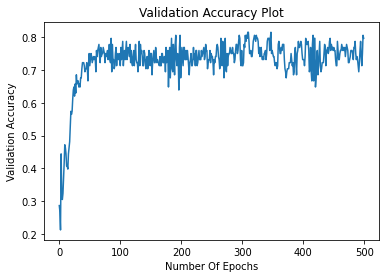

In [46]:
plt.plot(final.history['val_acc'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Number Of Epochs')
plt.title('Validation Accuracy Plot')
plt.show()

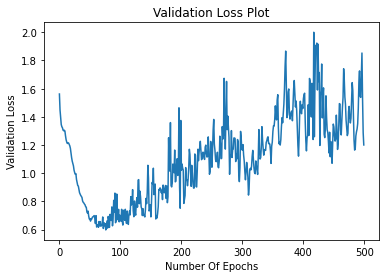

In [47]:
plt.plot(final.history['val_loss'])
plt.ylabel('Validation Loss')
plt.xlabel('Number Of Epochs')
plt.title('Validation Loss Plot')
plt.show()

In [48]:
compare_data = pd.DataFrame(columns=['File', 'Original Emotion', 'Predicted Emotion'])

In [49]:
for index,row in tqdm(test.iterrows()):
        file = row['file']
        emotion = row['emotion']
        with soundfile.SoundFile(file) as sound_file:
            signal = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
            feature = np.mean(find_mfcc(signal, sample_rate, 26), axis=0)
            result = cnn_model.predict_classes(feature.reshape(1,num_features,1))
            compare_data = compare_data.append({'File': file, 'Original Emotion': emotion ,'Predicted Emotion':label.inverse_transform(result)[0] }, ignore_index=True)

135it [00:03, 39.01it/s]


In [52]:
''' printing 10 random samples of prediction '''
print(compare_data.sample(10))

                               File Original Emotion Predicted Emotion
127  clean/03-01-04-02-02-01-13.wav              sad             happy
1    clean/03-01-03-01-02-02-11.wav            happy               sad
100  clean/03-01-04-01-02-02-17.wav              sad             angry
120  clean/03-01-05-02-02-02-11.wav            angry             angry
68   clean/03-01-01-01-01-01-15.wav          neutral             angry
7    clean/03-01-03-01-02-01-13.wav            happy             happy
117  clean/03-01-05-02-01-02-11.wav            angry             angry
9    clean/03-01-01-01-01-02-19.wav          neutral               sad
115  clean/03-01-05-01-01-01-05.wav            angry             angry
70   clean/03-01-05-01-02-01-15.wav            angry             angry
